In [1]:
import os
import csv
%load_ext autoreload
%autoreload 2

## Preprocessing

In [2]:
samples = []
with open("..\sim_data\driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

In [3]:
from sklearn.model_selection import train_test_split
train_samples, valid_samples = train_test_split(samples, test_size=0.2)

In [4]:
import cv2
import numpy as np
import sklearn

In [5]:
image_path = 'D:/udacity/sim_data/IMG/'
correction = 0.2 # steering_angle correction

In [6]:

# class(keras.utils.Sequence)  for multi-core processing.
def generator(samples, batch_size=32):
    nb_samples = len(samples)
    while True: # loop forever.
        sklearn.utils.shuffle(samples)
        for offset in range(0, nb_samples, batch_size):
            end = offset + batch_size
            batch_samples = samples[offset:end]
            
            images = []
            steering_angles = []
            
            for sample in batch_samples:
                steering_angle = float(sample[3]) 
                for i in range(3): 
                    source_path = sample[i]
                    filename = source_path.split('\\')[-1] # windows
                    current_path = image_path + filename
                    image = cv2.imread(current_path)
                    images.append(image)

                    #Seperate the steering_angle
                    if(i == 0): # center
                        steering_angles.append(steering_angle)
                    if(i == 1): # left
                        steering_angles.append(steering_angle + correction)
                    if(i == 2): # right
                        steering_angles.append(steering_angle - correction)
            
            #augmented_images = []
            #augmented_steering_angles= []
            ## Data augmentation with mirroring images
            #for image, steering_angle in zip(images, steering_angles):
            #    augmented_images.append(image)
            #    augmented_steering_angles.append(steering_angle)
            #    # Mirroring
            #    augmented_image.append(cv2.flip(image, 1))
            #    augmented_steering_angles.append(-1 * steering_angle)
            
            #X_train = np.array(augmented_images)
            #y_train = np.array(augmented_steering_angles)
            
            X_train = np.array(images)
            y_train = np.array(steering_angles)
            
            yield sklearn.utils.shuffle(X_train, y_train)

In [7]:
train_generator = generator(train_samples, batch_size = 32)
valid_generator = generator(valid_samples, batch_size = 32)

## Model

In [8]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers import Conv2D, MaxPooling2D

Using TensorFlow backend.


In [9]:
model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3)))
model.add(Lambda(lambda x: x/255.0 - 0.5)) # preprocessing  160x320x3
model.add(Conv2D(filters=6, kernel_size=[5,5], strides=[1,1], padding='same', activation='relu'))  #160x320x6
model.add(MaxPooling2D(pool_size=[2,2], strides=None, padding='same')) # 80 x160x6
model.add(Conv2D(filters=16, kernel_size=[5,5], strides=[1,1], padding='same', activation='relu')) #80 x160x16
model.add(MaxPooling2D(pool_size=[2,2], strides=None, padding='same')) # 40x 80 x16 
model.add(Conv2D(filters=32, kernel_size=[5,5], strides=[1,1], padding='same', activation='relu')) #40x 80x32
model.add(MaxPooling2D(pool_size=[2,2], strides=None, padding='same')) # 20x 40 x32
model.add(Conv2D(filters=64, kernel_size=[5,5], strides=[1,1], padding='same', activation='relu')) #20x 40x64
model.add(MaxPooling2D(pool_size=[2,2], strides=None, padding='same')) # 10x 20 x64
model.add(Flatten()) # 12800
model.add(Dense(2480, activation='relu'))
model.add(Dense(516, activation='relu'))
model.add(Dense(1))

In [10]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, steps_per_epoch= len(train_samples),
                              validation_data=valid_generator, validation_steps=len(valid_samples),
                              epochs=3, verbose=1)
model.save('model.h5')

Epoch 1/3
1797/1797 [==============================] - 752s - loss: 0.0157 - val_loss: 0.0215
Epoch 2/3
1797/1797 [==============================] - 644s - loss: 0.0020 - val_loss: 0.0199
Epoch 3/3
1797/1797 [==============================] - 645s - loss: 7.9063e-04 - val_loss: 0.0206


dict_keys(['val_loss', 'loss'])


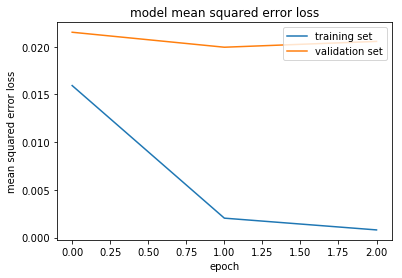

In [11]:
import matplotlib.pyplot as plt
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()